In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
train= pd.read_csv(r'C:\Users\anujc\Downloads\train_s3TEQDk.csv')
test=pd.read_csv(r"C:\Users\anujc\Downloads\test_mSzZ8RL.csv")

In [3]:
train.shape, test.shape

((245725, 11), (105312, 10))

In [4]:
train.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active',
       'Is_Lead'],
      dtype='object')

In [5]:
test.columns

Index(['ID', 'Gender', 'Age', 'Region_Code', 'Occupation', 'Channel_Code',
       'Vintage', 'Credit_Product', 'Avg_Account_Balance', 'Is_Active'],
      dtype='object')

In [6]:
train['source'] = 'train'
test['source'] = 'test'
data = pd.concat([train,test],ignore_index=True)

In [7]:
data.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead,source
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0.0,train
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0.0,train
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0.0,train
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0.0,train
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0.0,train


In [8]:
data.shape    

(351037, 12)

In [9]:
data.isnull().sum()

ID                          0
Gender                      0
Age                         0
Region_Code                 0
Occupation                  0
Channel_Code                0
Vintage                     0
Credit_Product          41847
Avg_Account_Balance         0
Is_Active                   0
Is_Lead                105312
source                      0
dtype: int64

In [10]:
train.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
source                     0
dtype: int64

In [11]:
test.isnull().sum()

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         12522
Avg_Account_Balance        0
Is_Active                  0
source                     0
dtype: int64

In [12]:
data.dtypes

ID                      object
Gender                  object
Age                      int64
Region_Code             object
Occupation              object
Channel_Code            object
Vintage                  int64
Credit_Product          object
Avg_Account_Balance      int64
Is_Active               object
Is_Lead                float64
source                  object
dtype: object

In [14]:
data.nunique()

ID                     351037
Gender                      2
Age                        63
Region_Code                35
Occupation                  4
Channel_Code                4
Vintage                    66
Credit_Product              2
Avg_Account_Balance    162137
Is_Active                   2
Is_Lead                     2
source                      2
dtype: int64

In [15]:
data['Credit_Product'].value_counts()

No     205965
Yes    103225
Name: Credit_Product, dtype: int64

In [16]:
data['Credit_Product'].replace(np.nan,'Yes',inplace=True)

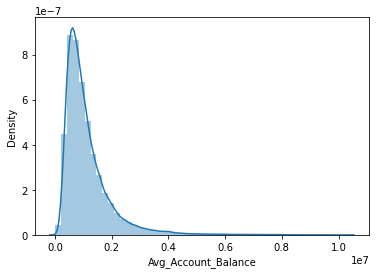

In [17]:
sns.distplot(data['Avg_Account_Balance'])
plt.show()

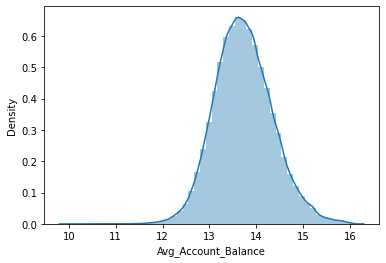

In [18]:
#####log transform to fix skewness
data['Avg_Account_Balance'] = np.log(data['Avg_Account_Balance']) 
sns.distplot(data['Avg_Account_Balance'])
plt.show()

In [19]:
train = data.loc[data['source']=="train"]
test = data.loc[data['source']=="test"]

In [20]:
#Drop unnecessary columns:
test.drop(['Is_Lead','source'],axis=1,inplace=True)
train.drop('source',axis=1,inplace=True)

In [21]:
train.drop('ID',axis=1,inplace=True)
test.drop("ID",axis=1,inplace = True)

In [22]:
train.dtypes

Gender                  object
Age                      int64
Region_Code             object
Occupation              object
Channel_Code            object
Vintage                  int64
Credit_Product          object
Avg_Account_Balance    float64
Is_Active               object
Is_Lead                float64
dtype: object

In [23]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
var_mod = ['Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active']
for i in var_mod:
    train[i] = le.fit_transform(train[i])
    test[i] = le.fit_transform(test[i])

In [24]:
X = train.drop('Is_Lead',axis=1)
y = train['Is_Lead']

In [25]:
##cross validation
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

def cross_val(X, y, model, params, folds=9):

    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=21)
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        print(f"Fold: {fold}")
        x_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        x_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

        alg = model(**params)
        alg.fit(x_train, y_train,
                eval_set=[(x_test, y_test)],
                early_stopping_rounds=100,
                verbose=400)

        pred = alg.predict_proba(x_test)[:, 1]
        roc_score = roc_auc_score(y_test, pred)
        print(f"roc_auc_score: {roc_score}")
        print("-"*50)
    
    return alg

In [26]:
lgb_params= {'learning_rate': 0.045, 
             'n_estimators': 20000, 
             'max_bin': 94,
             'num_leaves': 10, 
             'max_depth': 27, 
             'reg_alpha': 8.457, 
             'reg_lambda': 6.853, 
             'subsample': 0.749}

In [29]:
! pip install lightgbm
from lightgbm import LGBMClassifier
lgb_model = cross_val(X, y, LGBMClassifier, lgb_params)

Fold: 0
Training until validation scores don't improve for 100 rounds
[400]	valid_0's binary_logloss: 0.378501
[800]	valid_0's binary_logloss: 0.37827
Early stopping, best iteration is:
[802]	valid_0's binary_logloss: 0.378264
roc_auc_score: 0.8539183817995556
--------------------------------------------------
Fold: 1
Training until validation scores don't improve for 100 rounds
[400]	valid_0's binary_logloss: 0.382606
Early stopping, best iteration is:
[524]	valid_0's binary_logloss: 0.382519
roc_auc_score: 0.8500343931608946
--------------------------------------------------
Fold: 2
Training until validation scores don't improve for 100 rounds
[400]	valid_0's binary_logloss: 0.384762
Early stopping, best iteration is:
[607]	valid_0's binary_logloss: 0.38465
roc_auc_score: 0.847290061663613
--------------------------------------------------
Fold: 3
Training until validation scores don't improve for 100 rounds
[400]	valid_0's binary_logloss: 0.383285
Early stopping, best iteration is:


In [31]:
xgb_params= {'n_estimators': 20000, 
             'max_depth': 6, 
             'learning_rate': 0.0201, 
             'reg_lambda': 29.326, 
             'subsample': 0.818, 
             'colsample_bytree': 0.235, 
             'colsample_bynode': 0.820, 
             'colsample_bylevel': 0.453}

In [32]:
from xgboost import XGBClassifier
xgb_model = cross_val(X, y, XGBClassifier, xgb_params)

Fold: 0
[17:13:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.68734
[400]	validation_0-logloss:0.39726
[800]	validation_0-logloss:0.38761
[1200]	validation_0-logloss:0.38479
[1600]	validation_0-logloss:0.38353
[2000]	validation_0-logloss:0.38276
[2400]	validation_0-logloss:0.38214
[2800]	validation_0-logloss:0.38178
[3200]	validation_0-logloss:0.38151
[3600]	validation_0-logloss:0.38124
[4000]	validation_0-logloss:0.38097
[4294]	validation_0-logloss:0.38087
roc_auc_score: 0.8522862488182819
--------------------------------------------------
Fold: 1
[17:15:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric use

In [34]:
pred_test_lgb = lgb_model.predict_proba(test)[:,1]
pred_test_xgb = xgb_model.predict_proba(test)[:,1]

In [35]:
prediction = (pred_test_lgb + pred_test_xgb)/2

In [36]:
sample_submission=pd.read_csv(r'C:\Users\anujc\Downloads\sample_submission_eyYijxG.csv')

In [37]:
##creating seaparate files
sample_submission['Is_Lead'] = prediction
sample_submission.to_csv(f'submission.csv',index=False)

In [38]:
sample_submission['Is_Lead'] = pred_test_lgb
sample_submission.to_csv(f'pred_test_lgb.csv',index=False)

sample_submission['Is_Lead'] = pred_test_xgb
sample_submission.to_csv(f'pred_test_xgb.csv',index=False)